## Classifying Good Product Reviews: Deep Learning Model

### Organize imports

In [1]:
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%autosave 5

Autosaving every 5 seconds


### add check in order to see if TensorFlow with GPU is used

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9855489813237813305, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15770877952
 locality {
   bus_id: 1
 }
 incarnation: 5623224763006627716
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:02:00.0, compute capability: 6.1"]

### Set network parameters

In [3]:
# Dataset/Featurization Config
path = 'data/full_cols_good_50k.csv'
label = 'good'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = label + '_run_' + path.split('.')[0].split('_')[-1]
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/model_' + run_name + '.ckpt'
should_log_metrics = True

In [4]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [5]:
%%time
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

CPU times: user 8.38 s, sys: 152 ms, total: 8.53 s
Wall time: 8.54 s


### Configure dataset

In [6]:
%%time
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at data/full_cols_good_50k.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
doc list created: 50000
Tuning tf-idf classifier.


/u/44/prollm1/unix/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Featurizing training set.
Featurizing test set.
Finished configuring dataset.
CPU times: user 36min 19s, sys: 1min 37s, total: 37min 56s
Wall time: 7min 28s


### Prepare model configurations

In [7]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [8]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [9]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [10]:
# Run forward pass
logits, weights = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/u/44/prollm1/unix/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [11]:
# Initializing the variables
init = tf.global_variables_initializer()

### Train model

In [12]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.695298, Training Accuracy= 0.53333
Iter 300, Minibatch Loss= 0.641469, Training Accuracy= 0.73333
Iter 450, Minibatch Loss= 0.699551, Training Accuracy= 0.33333
Iter 600, Minibatch Loss= 0.639029, Training Accuracy= 0.60000
Iter 750, Minibatch Loss= 0.681501, Training Accuracy= 0.53333
Validation Accuracy: 0.58792
Validation Loss: 0.6795162


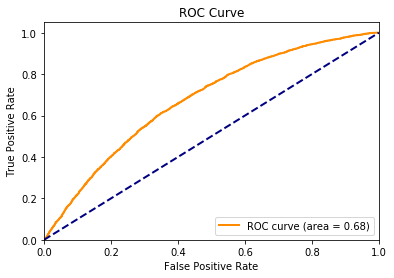

Iter 900, Minibatch Loss= 0.673586, Training Accuracy= 0.60000
Iter 1050, Minibatch Loss= 0.625853, Training Accuracy= 0.80000
Iter 1200, Minibatch Loss= 0.690564, Training Accuracy= 0.53333
Iter 1350, Minibatch Loss= 0.677733, Training Accuracy= 0.60000
Iter 1500, Minibatch Loss= 0.687299, Training Accuracy= 0.40000
Validation Accuracy: 0.6304
Validation Loss: 0.67217153


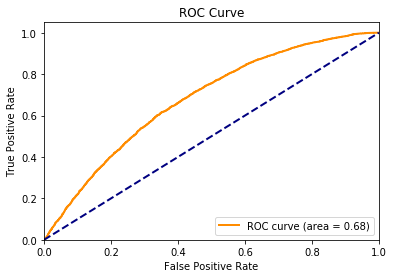

Iter 1650, Minibatch Loss= 0.656828, Training Accuracy= 0.60000
Iter 1800, Minibatch Loss= 0.555429, Training Accuracy= 0.80000
Iter 1950, Minibatch Loss= 0.564421, Training Accuracy= 0.66667
Iter 2100, Minibatch Loss= 0.673784, Training Accuracy= 0.53333
Iter 2250, Minibatch Loss= 0.593735, Training Accuracy= 0.66667
Validation Accuracy: 0.62384
Validation Loss: 0.65544045
Iter 2400, Minibatch Loss= 0.641976, Training Accuracy= 0.60000
Iter 2550, Minibatch Loss= 0.698457, Training Accuracy= 0.53333
Iter 2700, Minibatch Loss= 0.561642, Training Accuracy= 0.60000
Iter 2850, Minibatch Loss= 0.687600, Training Accuracy= 0.60000
Iter 3000, Minibatch Loss= 0.563226, Training Accuracy= 0.73333
Validation Accuracy: 0.63184
Validation Loss: 0.64095694


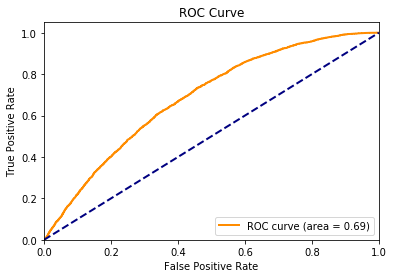

Iter 3150, Minibatch Loss= 0.539343, Training Accuracy= 0.60000
Iter 3300, Minibatch Loss= 0.551157, Training Accuracy= 0.73333
Iter 3450, Minibatch Loss= 0.681271, Training Accuracy= 0.60000
Iter 3600, Minibatch Loss= 0.671206, Training Accuracy= 0.53333
Iter 3750, Minibatch Loss= 0.599751, Training Accuracy= 0.60000
Validation Accuracy: 0.64536
Validation Loss: 0.6375112


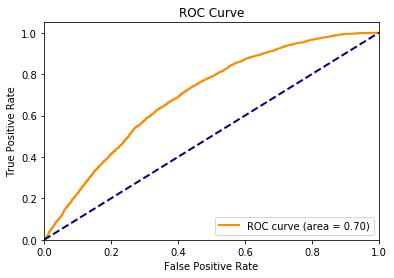

Iter 3900, Minibatch Loss= 0.549958, Training Accuracy= 0.66667
Iter 4050, Minibatch Loss= 0.658181, Training Accuracy= 0.53333
Iter 4200, Minibatch Loss= 0.671059, Training Accuracy= 0.60000
Iter 4350, Minibatch Loss= 0.760393, Training Accuracy= 0.46667
Iter 4500, Minibatch Loss= 0.638184, Training Accuracy= 0.66667
Validation Accuracy: 0.65168
Validation Loss: 0.6374605


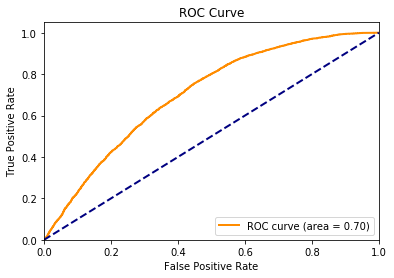

Iter 4650, Minibatch Loss= 0.566554, Training Accuracy= 0.66667
Iter 4800, Minibatch Loss= 0.761132, Training Accuracy= 0.40000
Iter 4950, Minibatch Loss= 0.609254, Training Accuracy= 0.66667
Iter 5100, Minibatch Loss= 0.712238, Training Accuracy= 0.46667
Iter 5250, Minibatch Loss= 0.616506, Training Accuracy= 0.80000
Validation Accuracy: 0.64216
Validation Loss: 0.6398711
Iter 5400, Minibatch Loss= 0.743520, Training Accuracy= 0.53333
Iter 5550, Minibatch Loss= 0.524739, Training Accuracy= 0.80000
Iter 5700, Minibatch Loss= 0.680425, Training Accuracy= 0.46667
Iter 5850, Minibatch Loss= 0.604846, Training Accuracy= 0.73333
Iter 6000, Minibatch Loss= 0.725271, Training Accuracy= 0.46667
Validation Accuracy: 0.6492
Validation Loss: 0.6278761
Iter 6150, Minibatch Loss= 0.502995, Training Accuracy= 0.73333
Iter 6300, Minibatch Loss= 0.800564, Training Accuracy= 0.46667
Iter 6450, Minibatch Loss= 0.689566, Training Accuracy= 0.46667
Iter 6600, Minibatch Loss= 0.608621, Training Accuracy= 0

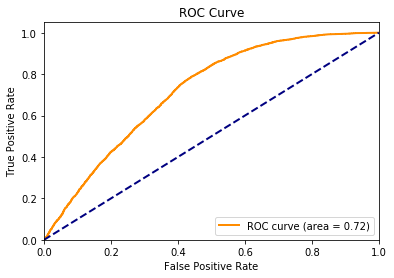

Iter 7650, Minibatch Loss= 0.526754, Training Accuracy= 0.86667
Iter 7800, Minibatch Loss= 0.576889, Training Accuracy= 0.60000
Iter 7950, Minibatch Loss= 0.728425, Training Accuracy= 0.66667
Iter 8100, Minibatch Loss= 0.482154, Training Accuracy= 0.86667
Iter 8250, Minibatch Loss= 0.587959, Training Accuracy= 0.73333
Validation Accuracy: 0.68352
Validation Loss: 0.605211


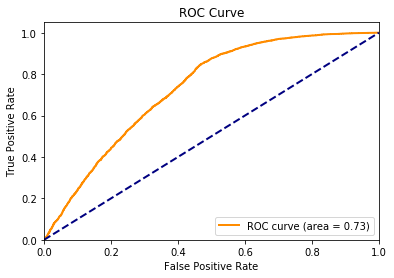

Iter 8400, Minibatch Loss= 0.526586, Training Accuracy= 0.73333
Iter 8550, Minibatch Loss= 0.573156, Training Accuracy= 0.66667
Iter 8700, Minibatch Loss= 0.617248, Training Accuracy= 0.60000
Iter 8850, Minibatch Loss= 0.607214, Training Accuracy= 0.66667
Iter 9000, Minibatch Loss= 0.591978, Training Accuracy= 0.66667
Validation Accuracy: 0.7088
Validation Loss: 0.58450794


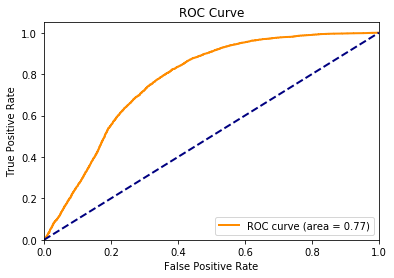

Iter 9150, Minibatch Loss= 0.525191, Training Accuracy= 0.80000
Iter 9300, Minibatch Loss= 0.527337, Training Accuracy= 0.80000
Iter 9450, Minibatch Loss= 0.736057, Training Accuracy= 0.40000
Iter 9600, Minibatch Loss= 0.717461, Training Accuracy= 0.46667
Iter 9750, Minibatch Loss= 0.512423, Training Accuracy= 0.86667
Validation Accuracy: 0.58608
Validation Loss: 0.6514029
Iter 9900, Minibatch Loss= 0.771592, Training Accuracy= 0.60000
Iter 10050, Minibatch Loss= 0.531081, Training Accuracy= 0.80000
Iter 10200, Minibatch Loss= 0.725332, Training Accuracy= 0.60000
Iter 10350, Minibatch Loss= 0.847340, Training Accuracy= 0.66667
Iter 10500, Minibatch Loss= 0.458600, Training Accuracy= 0.86667
Validation Accuracy: 0.68752
Validation Loss: 0.60545194
Iter 10650, Minibatch Loss= 0.615282, Training Accuracy= 0.66667
Iter 10800, Minibatch Loss= 0.590871, Training Accuracy= 0.66667
Iter 10950, Minibatch Loss= 0.705090, Training Accuracy= 0.60000
Iter 11100, Minibatch Loss= 0.605701, Training A

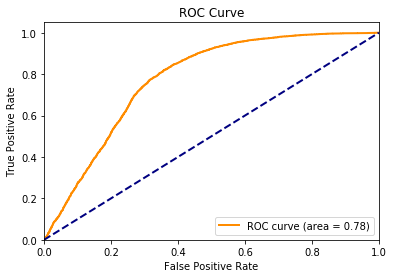

Iter 12900, Minibatch Loss= 0.586507, Training Accuracy= 0.73333
Iter 13050, Minibatch Loss= 0.805206, Training Accuracy= 0.40000
Iter 13200, Minibatch Loss= 0.562430, Training Accuracy= 0.80000
Iter 13350, Minibatch Loss= 0.531074, Training Accuracy= 0.73333
Iter 13500, Minibatch Loss= 0.455489, Training Accuracy= 0.86667
Validation Accuracy: 0.7144
Validation Loss: 0.5823389
Iter 13650, Minibatch Loss= 0.639921, Training Accuracy= 0.73333
Iter 13800, Minibatch Loss= 0.547538, Training Accuracy= 0.66667
Iter 13950, Minibatch Loss= 0.627845, Training Accuracy= 0.60000
Iter 14100, Minibatch Loss= 0.555217, Training Accuracy= 0.86667
Iter 14250, Minibatch Loss= 0.454626, Training Accuracy= 0.93333
Validation Accuracy: 0.68856
Validation Loss: 0.59199214
Iter 14400, Minibatch Loss= 0.640948, Training Accuracy= 0.66667
Iter 14550, Minibatch Loss= 0.461343, Training Accuracy= 0.80000
Iter 14700, Minibatch Loss= 0.432105, Training Accuracy= 0.86667
Iter 14850, Minibatch Loss= 0.540536, Train

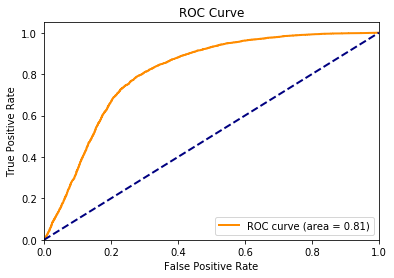

Iter 15900, Minibatch Loss= 0.538043, Training Accuracy= 0.73333
Iter 16050, Minibatch Loss= 0.619295, Training Accuracy= 0.80000
Iter 16200, Minibatch Loss= 0.578587, Training Accuracy= 0.73333
Iter 16350, Minibatch Loss= 0.414356, Training Accuracy= 0.86667
Iter 16500, Minibatch Loss= 0.528505, Training Accuracy= 0.80000
Validation Accuracy: 0.71544
Validation Loss: 0.56705153
Iter 16650, Minibatch Loss= 0.502665, Training Accuracy= 0.86667
Iter 16800, Minibatch Loss= 0.332368, Training Accuracy= 1.00000
Iter 16950, Minibatch Loss= 0.502578, Training Accuracy= 0.73333
Iter 17100, Minibatch Loss= 0.627657, Training Accuracy= 0.53333
Iter 17250, Minibatch Loss= 0.391550, Training Accuracy= 0.86667
Validation Accuracy: 0.71968
Validation Loss: 0.56105345
Iter 17400, Minibatch Loss= 0.482002, Training Accuracy= 0.86667
Iter 17550, Minibatch Loss= 0.771154, Training Accuracy= 0.40000
Iter 17700, Minibatch Loss= 0.554778, Training Accuracy= 0.66667
Iter 17850, Minibatch Loss= 0.734788, Tra

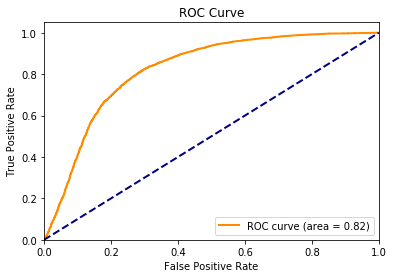

Iter 20400, Minibatch Loss= 0.445393, Training Accuracy= 0.86667
Iter 20550, Minibatch Loss= 0.706696, Training Accuracy= 0.53333
Iter 20700, Minibatch Loss= 0.244871, Training Accuracy= 1.00000
Iter 20850, Minibatch Loss= 0.291554, Training Accuracy= 0.93333
Iter 21000, Minibatch Loss= 0.550551, Training Accuracy= 0.73333
Validation Accuracy: 0.59432
Validation Loss: 0.7583842
Iter 21150, Minibatch Loss= 0.784255, Training Accuracy= 0.46667
Iter 21300, Minibatch Loss= 0.688535, Training Accuracy= 0.73333
Iter 21450, Minibatch Loss= 0.442061, Training Accuracy= 0.80000
Iter 21600, Minibatch Loss= 0.383069, Training Accuracy= 0.86667
Iter 21750, Minibatch Loss= 0.436592, Training Accuracy= 0.86667
Validation Accuracy: 0.73976
Validation Loss: 0.5581036
Iter 21900, Minibatch Loss= 0.627996, Training Accuracy= 0.46667
Iter 22050, Minibatch Loss= 0.422507, Training Accuracy= 0.80000
Iter 22200, Minibatch Loss= 0.262090, Training Accuracy= 1.00000
Iter 22350, Minibatch Loss= 0.643039, Train

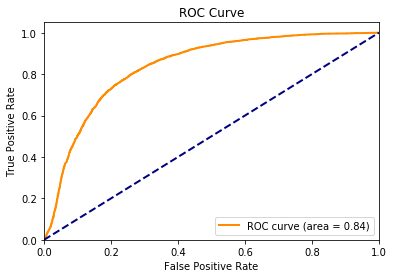

Iter 26400, Minibatch Loss= 0.567983, Training Accuracy= 0.66667
Iter 26550, Minibatch Loss= 0.516913, Training Accuracy= 0.73333
Iter 26700, Minibatch Loss= 0.672645, Training Accuracy= 0.53333
Iter 26850, Minibatch Loss= 0.423805, Training Accuracy= 0.86667
Iter 27000, Minibatch Loss= 0.752752, Training Accuracy= 0.60000
Validation Accuracy: 0.7564
Validation Loss: 0.5136117
Iter 27150, Minibatch Loss= 0.514760, Training Accuracy= 0.73333
Iter 27300, Minibatch Loss= 0.402155, Training Accuracy= 0.80000
Iter 27450, Minibatch Loss= 0.593757, Training Accuracy= 0.73333
Iter 27600, Minibatch Loss= 0.618011, Training Accuracy= 0.73333
Iter 27750, Minibatch Loss= 0.727405, Training Accuracy= 0.53333
Validation Accuracy: 0.69392
Validation Loss: 0.5817039
Iter 27900, Minibatch Loss= 0.346569, Training Accuracy= 0.93333
Iter 28050, Minibatch Loss= 0.576039, Training Accuracy= 0.73333
Iter 28200, Minibatch Loss= 0.555133, Training Accuracy= 0.73333
Iter 28350, Minibatch Loss= 0.304876, Traini

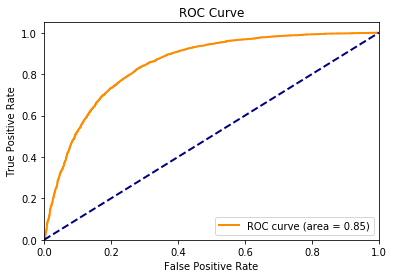

Iter 39900, Minibatch Loss= 0.660705, Training Accuracy= 0.73333
Iter 40050, Minibatch Loss= 0.445777, Training Accuracy= 0.80000
Iter 40200, Minibatch Loss= 0.336384, Training Accuracy= 0.86667
Iter 40350, Minibatch Loss= 0.430892, Training Accuracy= 0.80000
Iter 40500, Minibatch Loss= 0.570805, Training Accuracy= 0.66667
Validation Accuracy: 0.72848
Validation Loss: 0.54206204
Iter 40650, Minibatch Loss= 0.522117, Training Accuracy= 0.73333
Iter 40800, Minibatch Loss= 0.377517, Training Accuracy= 0.86667
Iter 40950, Minibatch Loss= 0.419448, Training Accuracy= 0.80000
Iter 41100, Minibatch Loss= 0.602261, Training Accuracy= 0.66667
Iter 41250, Minibatch Loss= 0.618349, Training Accuracy= 0.73333
Validation Accuracy: 0.76448
Validation Loss: 0.5104968
Iter 41400, Minibatch Loss= 0.470328, Training Accuracy= 0.66667
Iter 41550, Minibatch Loss= 0.552013, Training Accuracy= 0.86667
Iter 41700, Minibatch Loss= 0.464598, Training Accuracy= 0.86667
Iter 41850, Minibatch Loss= 0.572474, Trai

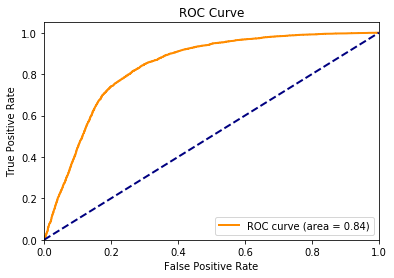

Iter 42150, Minibatch Loss= 0.373230, Training Accuracy= 0.80000
Iter 42300, Minibatch Loss= 0.424648, Training Accuracy= 0.73333
Iter 42450, Minibatch Loss= 0.534525, Training Accuracy= 0.80000
Iter 42600, Minibatch Loss= 0.498540, Training Accuracy= 0.73333
Iter 42750, Minibatch Loss= 0.371230, Training Accuracy= 0.86667
Validation Accuracy: 0.758
Validation Loss: 0.5131673
Iter 42900, Minibatch Loss= 0.540290, Training Accuracy= 0.73333
Iter 43050, Minibatch Loss= 0.379885, Training Accuracy= 0.93333
Iter 43200, Minibatch Loss= 0.709623, Training Accuracy= 0.60000
Iter 43350, Minibatch Loss= 0.389069, Training Accuracy= 0.80000
Iter 43500, Minibatch Loss= 0.620034, Training Accuracy= 0.66667
Validation Accuracy: 0.7648
Validation Loss: 0.5093962
Iter 43650, Minibatch Loss= 0.515487, Training Accuracy= 0.66667
Iter 43800, Minibatch Loss= 0.840265, Training Accuracy= 0.60000
Iter 43950, Minibatch Loss= 0.573592, Training Accuracy= 0.73333
Iter 44100, Minibatch Loss= 0.575791, Training

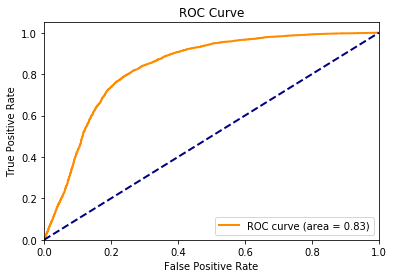

Iter 60900, Minibatch Loss= 0.467088, Training Accuracy= 0.80000
Iter 61050, Minibatch Loss= 0.440074, Training Accuracy= 0.80000
Iter 61200, Minibatch Loss= 0.322225, Training Accuracy= 0.86667
Iter 61350, Minibatch Loss= 0.410736, Training Accuracy= 0.73333
Iter 61500, Minibatch Loss= 0.352685, Training Accuracy= 0.86667
Validation Accuracy: 0.766
Validation Loss: 0.49900016
Iter 61650, Minibatch Loss= 0.473701, Training Accuracy= 0.80000
Iter 61800, Minibatch Loss= 0.318356, Training Accuracy= 0.93333
Iter 61950, Minibatch Loss= 0.246818, Training Accuracy= 0.93333
Iter 62100, Minibatch Loss= 0.618087, Training Accuracy= 0.66667
Iter 62250, Minibatch Loss= 0.250690, Training Accuracy= 0.93333
Validation Accuracy: 0.772
Validation Loss: 0.4943119
Iter 62400, Minibatch Loss= 0.334990, Training Accuracy= 0.80000
Iter 62550, Minibatch Loss= 0.380498, Training Accuracy= 0.80000
Iter 62700, Minibatch Loss= 0.212520, Training Accuracy= 1.00000
Iter 62850, Minibatch Loss= 0.430334, Training

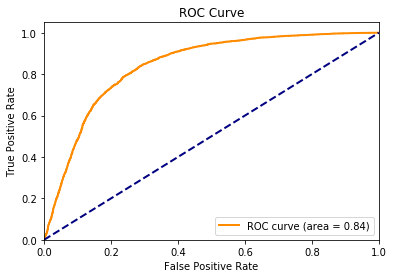

Iter 72900, Minibatch Loss= 0.274955, Training Accuracy= 0.93333
Iter 73050, Minibatch Loss= 0.623022, Training Accuracy= 0.73333
Iter 73200, Minibatch Loss= 0.340834, Training Accuracy= 0.93333
Iter 73350, Minibatch Loss= 0.532532, Training Accuracy= 0.80000
Iter 73500, Minibatch Loss= 0.467064, Training Accuracy= 0.73333
Validation Accuracy: 0.77032
Validation Loss: 0.49309608
Iter 73650, Minibatch Loss= 0.186618, Training Accuracy= 1.00000
Iter 73800, Minibatch Loss= 0.482780, Training Accuracy= 0.80000
Iter 73950, Minibatch Loss= 0.494233, Training Accuracy= 0.73333
Iter 74100, Minibatch Loss= 0.491249, Training Accuracy= 0.73333
Iter 74250, Minibatch Loss= 0.499695, Training Accuracy= 0.60000
Validation Accuracy: 0.77272
Validation Loss: 0.49392524
Iter 74400, Minibatch Loss= 0.300373, Training Accuracy= 0.80000
Iter 74550, Minibatch Loss= 0.966772, Training Accuracy= 0.40000
Iter 74700, Minibatch Loss= 0.500121, Training Accuracy= 0.73333
Iter 74850, Minibatch Loss= 0.508374, Tra

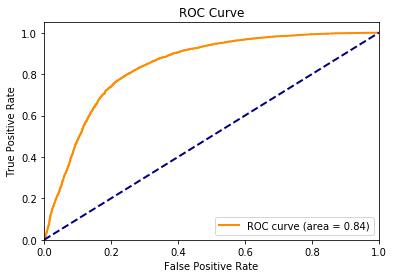

Iter 87150, Minibatch Loss= 0.487908, Training Accuracy= 0.80000
Iter 87300, Minibatch Loss= 0.240780, Training Accuracy= 0.86667
Iter 87450, Minibatch Loss= 0.327747, Training Accuracy= 0.86667
Iter 87600, Minibatch Loss= 0.449505, Training Accuracy= 0.73333
Iter 87750, Minibatch Loss= 0.395255, Training Accuracy= 0.80000
Validation Accuracy: 0.76328
Validation Loss: 0.496542
Iter 87900, Minibatch Loss= 0.589134, Training Accuracy= 0.80000
Iter 88050, Minibatch Loss= 0.681714, Training Accuracy= 0.73333
Iter 88200, Minibatch Loss= 0.455474, Training Accuracy= 0.73333
Iter 88350, Minibatch Loss= 0.351046, Training Accuracy= 0.80000
Iter 88500, Minibatch Loss= 0.443427, Training Accuracy= 0.86667
Validation Accuracy: 0.76664
Validation Loss: 0.50349677
Iter 88650, Minibatch Loss= 0.679516, Training Accuracy= 0.66667
Iter 88800, Minibatch Loss= 0.538070, Training Accuracy= 0.80000
Iter 88950, Minibatch Loss= 0.596127, Training Accuracy= 0.73333
Iter 89100, Minibatch Loss= 0.464914, Train

In [13]:
%%time
best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.savefig('plots/' + run_name + '_step_' + str(step) + '.png', dpi=300, bbox_inches='tight')
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))

### Read out the final weight matrix and save it to disk

In [14]:
w = sess.run(weights)
n_fc = len(fc_layer_sizes) + 1

for i in range(n_fc):
    f_name = 'weights/' + label + '_dim_' + str(i) + '.csv'
    np.savetxt(f_name, w[i], delimiter=',')